<a href="https://colab.research.google.com/github/SourCherries/VAE-GAN-CelebA/blob/master/visualize_celeba_15_AFC_sheldon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/SourCherries/VAE-GAN-CelebA.git

%tensorflow_version 1.x

import sys, getopt
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher.\n')
print(sys.version)

sys.path.insert(0,'/content/VAE-GAN-CelebA/libs')
sys.path.insert(0,'/content/VAE-GAN-CelebA/')

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import libs.make_network as make_network
import libs.utils as utils
from scipy.io import loadmat, savemat
import imageio
from skimage.util import montage
import pandas as pd
import seaborn as sns

import zipfile
import io
from PIL import Image
from torchvision import transforms

print('TF version = ',tf.__version__)

# Download Tensorflow checkpoint
! gdown --id 1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV

# CelebA
# https://drive.google.com/file/d/172v_Sfx-MyE2nS59jxl6W9-so3Xvyhkj/view?usp=sharing
! gdown --id 172v_Sfx-MyE2nS59jxl6W9-so3Xvyhkj



Cloning into 'VAE-GAN-CelebA'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 215 (delta 61), reused 98 (delta 46), pack-reused 86
Receiving objects: 100% (215/215), 7.25 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (99/99), done.
After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TF version =  1.15.2
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV
To: /content/vaegan_celeba.ckpt
100

## Model

In [2]:
sess, X, G, Z, Z_mu, is_training, saver = make_network.make_network()

if os.path.exists("vaegan_celeba.ckpt"):
    saver.restore(sess, "vaegan_celeba.ckpt")
    print("VAE-GAN model restored.")
else:
    print("Pre-trained network appears to be missing.")
    sys.exit()






encoder/input: [None, 128, 128, 3]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

layer: 0 , shape: [None, 64, 64, 192]
layer: 1 , shape: [None, 32, 32, 256]
layer: 2 , shape: [None, 16, 16, 384]
layer: 3 , shape: [None, 8, 8, 512]
layer: 4 , shape: [None, 4, 4, 768]


Instructions for updating:
Use `tf.global_variables_initializer` instead.

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from vaegan_celeba.ckpt
VAE-GAN model restored.


## Mean Z for 15 identities
Final is Sheldon, first 7 are most similar to Sheldon, and next 7 have mean Z that are orthogonal to Sheldon.

In [3]:
z_file = "/content/VAE-GAN-CelebA/celeba-15-AFC-sheldon-last"
MZ = np.fromfile(z_file)
MZ = MZ.reshape(15, 1025)
ID = MZ[:, 0]
MZ = MZ[:, 1:]

## Batchwise convert to images

In [ ]:
# print(MZ.shape)
# print(MZ.dtype)
# print(MZ[0,:].mean())
# print(MZ[0,:].min())
# print(MZ[0,:].max())

In [4]:
g = sess.run(G, feed_dict={Z: (1*MZ), is_training: False})


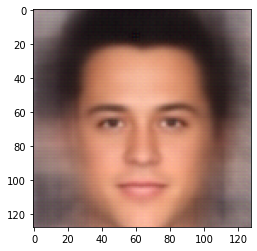

ID = 9040.0


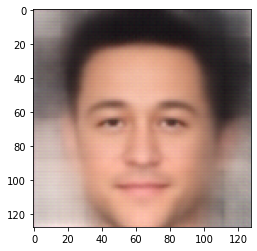

ID = 4895.0


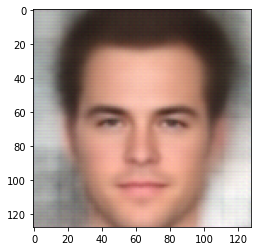

ID = 1869.0


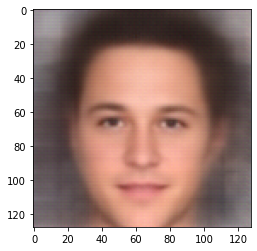

ID = 8742.0


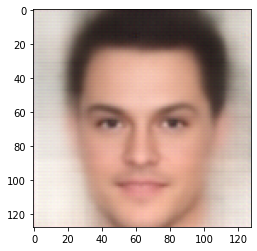

ID = 6567.0


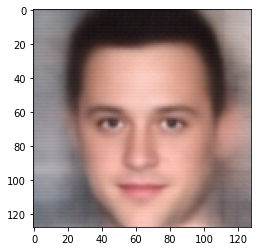

ID = 2777.0


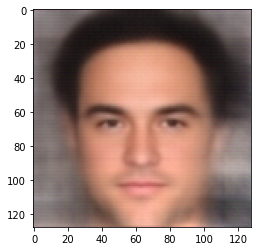

ID = 4820.0


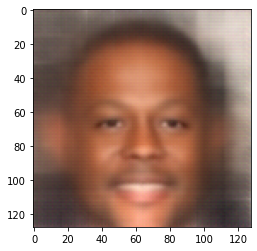

ID = 3229.0


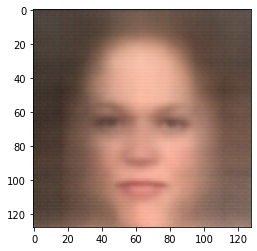

ID = 2881.0


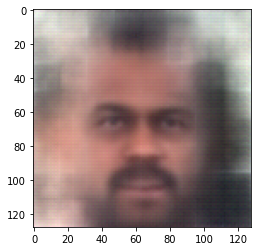

ID = 7521.0


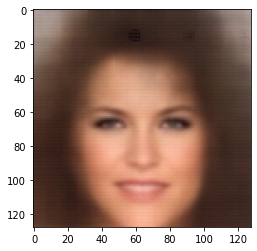

ID = 6063.0


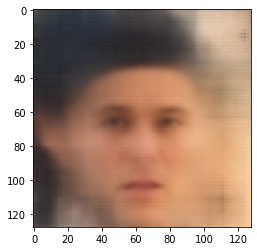

ID = 8977.0


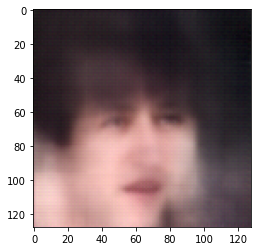

ID = 6968.0


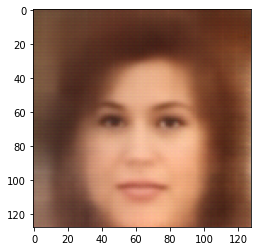

ID = 2923.0


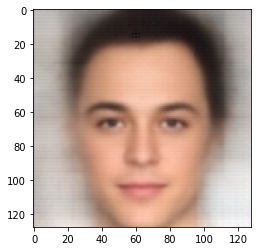

ID = 3915.0


In [5]:
def imdeprocess(g):
    stretch = 1.0
    for i in range(g.shape[0]):
        g[i]=np.clip(stretch*g[i] / (g.max()),0,1)
    return g


for ind, gg in enumerate(g):
  img = imdeprocess(gg)
  plt.imshow(img); plt.show(); print(f'ID = {ID[ind]}')

# Checks

Most confusable face (first) looks almost exactly like Sheldon's (last).
* Match images
* Compare originals for 3915 (distractor) and 4610 (target)

**Fixed. 3915 and 4610 both Sheldon. Chose 3915 as target and removed 4610 from consideration in below**

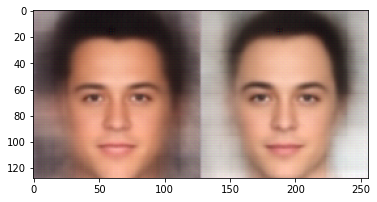

In [6]:
first = imdeprocess(g[0])
last = imdeprocess(g[-1])
plt.imshow(np.concatenate((first, last), axis=1))

In [7]:
labels = pd.read_csv("/content/VAE-GAN-CelebA/identity_CelebA.txt", header=None, sep="\s+", names=["file","id"])

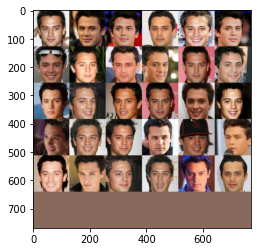

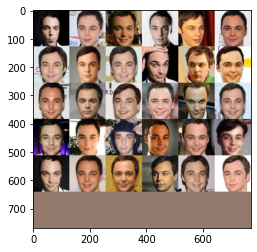

In [9]:
from skimage.util import montage

zippyzocker = zipfile.ZipFile("img_align_celeba.zip")

files_dis = labels[labels.id == 9040]
files = list(files_dis["file"])
imgs = np.zeros((len(files), 128, 128, 3))
for ind, f in enumerate(files):
  file_in_zip = "img_align_celeba/" + f
  data = zippyzocker.read(file_in_zip)
  dataEnc = io.BytesIO(data)
  img = Image.open(dataEnc)
  img = utils.preprocess128(np.array(img),crop_factor=0.8)[np.newaxis]
  imgs[ind, :, :, :] = img  
imgm = montage(imgs, multichannel=True)
plt.imshow(imgm)
plt.savefig("sheldon-distractors-9040.png")
plt.show()

files_tar = labels[labels.id == 3915]
files = list(files_tar["file"])
imgs = np.zeros((len(files), 128, 128, 3))
for ind, f in enumerate(files):
  file_in_zip = "img_align_celeba/" + f
  data = zippyzocker.read(file_in_zip)
  dataEnc = io.BytesIO(data)
  img = Image.open(dataEnc)
  img = utils.preprocess128(np.array(img),crop_factor=0.8)[np.newaxis]
  imgs[ind, :, :, :] = img  
imgm = montage(imgs, multichannel=True)
plt.imshow(imgm)
plt.savefig("sheldon-target-3914.png")
plt.show()

# Duplicate identities
Identity numbers 3915 (first) and 4610 (last) both correspond to Sheldon.

Use the first one, 3915.

So remove 4610 when choosing targets.